# Банки — Анализ оттока клиентов
---


## Материалы
---
* [Дашборд](https://public.tableau.com/views/Project_final_16857298399680/Dashboard1?:language=en-GB&publish=yes&:display_count=n&:origin=viz_share_link)
* [Презентация](https://drive.google.com/file/d/1wbxudKwBe4zeTKiBVdaJNGwZCV5TbwQB/view?usp=sharing)

## Описание проекта
---
**Заказчик** - региональный банк «Метанпром», который "терпит крушение" из-за оттока критической массы клиентов.

В распоряжении присуствует **датасет**, с обезличенными данными пользователей.

**Колонки датасета:**
- `userid` — идентификатор пользователя,
- `score` — баллы кредитного скоринга,
- `City` — город,
- `Gender` — пол,
- `Age` — возраст,
- `Objects` — количество объектов в собственности
- `Balance` — баланс на счёте,
- `Products` — количество продуктов, которыми пользуется клиент,
- `CreditCard` — есть ли кредитная карта,
- `Loyalty` — активный клиент (да/нет),
- `estimated_salary` — заработная плата клиента,
- `Churn` — ушёл или нет.


## Постановка задачи
---

**Задача:** представить анализ клиентов регионального банка и **обозначить сегменты** (портреты групп, определенных 2-3 признаками) клиентов, **которые склонны отказываться от услуг** этого банка.

**Результаты:** представить презентацию и дашборд, которые способены продемонстрировать результаты исследования.

## Загрузка и изучение данных
---


### Библиотеки
---

In [ ]:
#importing lib-s and preferences
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import numpy as np
import matplotlib.ticker as ticker
import scipy as sc
import datetime as dt
import math as mth
from datetime import datetime, timedelta
from scipy import stats as st
pd.set_option('display.max_columns', None) #for displaying all columns
pd.set_option('display.max_colwidth', None) #for displaying full widht of columns
from plotly import graph_objects as go
import plotly.express as px
import warnings; warnings.filterwarnings(action = 'ignore') #for warnings=OFF

### Функции
---

In [ ]:
#function, which shows head, tail, info, description, duplicates, counts Nan's and etc. of DF

def starting_pack(data):
    print('Основная информация о датафрейме:')
    data.info()
    print()
    print('Строки начала датафрейма:')
    display(data.head())
    print('Строки конца датафрейма:')
    display(data.tail())
    print('Количество дубликатов:')
    display(data.duplicated().sum())
    print('Количество пропусков:')
    display(data.isna().sum())
    print('Описание датафрейма:')
    display(data.describe())

In [ ]:
# function, which draws graphs of distribution (histogram + boxplot)

def distribution(column):
  fig, ax = plt.subplots(figsize=(15,5), sharex = True, sharey = True)
  #common naming
  fig.suptitle('Гистограмма распределения и ящик с усами колонки ' + column)

  #histplot
  sns.histplot(data[column], ax = plt.subplot(1, 2, 1))
  plt.ylabel('Количество клиентов')
  plt.grid(which='major',
       color = 'black',
       alpha=0.3,
       axis = 'x')

  #boxplot
  sns.boxplot(x=data[column], ax = plt.subplot(1, 2, 2))

  plt.show();

In [ ]:
# function, which draws graphs of aggregated data by name of column

def aggregation(column):
  #aggregating
  temp_df = (data
      .groupby(column)
      .agg({'age':'count'})
      )
  #drawing
  plt.figure(figsize=(12, 5))

  #barplot
  sns.barplot(x='age', y=temp_df.index, data=temp_df, palette='Blues_r', alpha=1, orient='h')
  plt.title('Распределение клиентов по '+column)
  plt.xlabel('Количество клиентов')
  plt.ylabel(column)
  plt.grid(which='major',
       color = 'black',
       alpha=0.3,
       axis = 'x')
  plt.show()


In [ ]:
# function, which draws graphs of data by name of the column with churn marker

def churn_distribution(column):

  fig, ax = plt.subplots(figsize=(15,5))
  #common naming
  fig.suptitle('Гистограмма распределения и ящик с усами колонки '+ column + ' с разделением по признаку оттока')

  # histplot
  sns.histplot(data=data.query('churn == 0'), x=column, palette='Blues_r', label='удержанные клиенты',alpha=0.7, ax = plt.subplot(1, 2, 1))
  sns.histplot(data=data.query('churn == 1'), x=column, color='orange', label='отточные клиенты', alpha=0.8, ax = plt.subplot(1, 2, 1))
  plt.ylabel('Количество клиентов')
  plt.grid(which='major',
        color = 'black',
        alpha=0.3,
        axis = 'x')
  plt.legend()

  #boxplot
  sns.boxplot(y=column, x='churn', data = data, ax = plt.subplot(1, 2, 2))
  plt.grid(which='major',
        color = 'black',
        alpha=0.3,
        axis = 'y')

  plt.show()

In [ ]:
# function, which draws barplots by name of the columns with churn marker (percentage of total)

def churn_aggregation(column):
    temp_1 = data.groupby(column).agg(count=('age','count')).reset_index()
    temp_1['percentage'] = round(temp_1['count']/temp_1['count']*100,2)
    temp_2 = (data
                .query('churn == 1')
                .groupby(column)
                .agg(count=('age','count'))
                .reset_index()
        )
    temp_2['percentage'] = round(temp_2['count']/temp_1['count']*100,2)

    plt.figure(figsize=(8, 5))

    ax = sns.barplot(x=column, y='percentage',data=temp_2, orient='v',palette='Reds_r', alpha=1)
    ax.axhline(round(data['churn'].mean()*100,2), ls='dashdot', label='Средний уровень оттока', c='green')

    for bar in ax.patches:
        ax.annotate(format(bar.get_height(), '.2f'),
                       (bar.get_x() + bar.get_width() / 2,
                        bar.get_height()), ha='center', va='center',
                       size=8, xytext=(0, 5),
                       textcoords='offset points')

    plt.title('Доля отточных клиентов с разбивкой по '+column )
    plt.xlabel(column)
    plt.ylabel('Доли клиентов, % от общего')
    plt.legend()
    plt.show()

### Загрузка датасета
---

In [ ]:
# openning file from common directory
url = 'https://raw.githubusercontent.com/Bagg1n5/datasets/main/bank_dataset.csv'
data = pd.read_csv(url)

In [ ]:
data.head()

,userid,score,City,Gender,Age,Objects,Balance,Products,CreditCard,Loyalty,estimated_salary,Churn
0,15677338,619,Ярославль,Ж,42,2,NaN,1,1,1,101348.88,1
1,15690047,608,Рыбинск,Ж,41,1,83807.86,1,0,1,112542.58,0
2,15662040,502,Ярославль,Ж,42,8,159660.80,3,1,0,113931.57,1
3,15744090,699,Ярославль,Ж,39,1,NaN,2,0,0,93826.63,0
4,15780624,850,Рыбинск,Ж,43,2,125510.82,1,1,1,79084.10,0


### Изучение данных
---

Запустим функцию `starting_pack`, которая выведет общую информацию о датасете.

In [ ]:
starting_pack(data)

Основная информация о датафрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   userid            10000 non-null  int64  
 1   score             10000 non-null  int64  
 2   City              10000 non-null  object 
 3   Gender            10000 non-null  object 
 4   Age               10000 non-null  int64  
 5   Objects           10000 non-null  int64  
 6   Balance           6383 non-null   float64
 7   Products          10000 non-null  int64  
 8   CreditCard        10000 non-null  int64  
 9   Loyalty           10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  Churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB

Строки начала датафрейма:


,userid,score,City,Gender,Age,Objects,Balance,Products,CreditCard,Loyalty,estimated_salary,Churn
0,15677338,619,Ярославль,Ж,42,2,NaN,1,1,1,101348.88,1
1,15690047,608,Рыбинск,Ж,41,1,83807.86,1,0,1,112542.58,0
2,15662040,502,Ярославль,Ж,42,8,159660.80,3,1,0,113931.57,1
3,15744090,699,Ярославль,Ж,39,1,NaN,2,0,0,93826.63,0
4,15780624,850,Рыбинск,Ж,43,2,125510.82,1,1,1,79084.10,0


Строки конца датафрейма:


,userid,score,City,Gender,Age,Objects,Balance,Products,CreditCard,Loyalty,estimated_salary,Churn
9995,15648965,771,Ярославль,М,39,5,NaN,2,1,0,96270.64,0
9996,15612628,516,Ярославль,М,35,10,57369.61,1,1,1,101699.77,0
9997,15627268,709,Ярославль,Ж,36,7,NaN,1,0,1,42085.58,1
9998,15725091,772,Ростов Великий,М,42,3,75075.31,2,1,0,92888.52,1
9999,15671055,792,Ярославль,Ж,28,4,130142.79,1,1,0,38190.78,0


Количество дубликатов:


0

Количество пропусков:


userid                 0
score                  0
City                   0
Gender                 0
Age                    0
Objects                0
Balance             3617
Products               0
CreditCard             0
Loyalty                0
estimated_salary       0
Churn                  0
dtype: int64

Описание датафрейма:


,userid,score,Age,Objects,Balance,Products,CreditCard,Loyalty,estimated_salary,Churn
count,1.000000e+04,10000.000000,10000.000000,10000.000000,6383.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,1.573368e+07,650.528800,38.921800,5.012800,119827.493793,1.530200,0.70550,0.515100,100090.239881,0.203700
std,7.193619e+04,96.653299,10.487806,2.892174,30095.056462,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.560844e+07,350.000000,18.000000,0.000000,3768.690000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,1.567126e+07,584.000000,32.000000,3.000000,100181.975000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,1.573347e+07,652.000000,37.000000,5.000000,119839.690000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,1.579597e+07,718.000000,44.000000,7.000000,139512.290000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,1.585843e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


1. Возраст клиентов от 18 до 92 лет;
2. Количество объектов в собственности от 0 до 10;
3. Баллы кредитного скоринга от 350 до 850;
4. Количество продуктов банка, которыми пользуется клиенты от 1 до 4;
5. Кредитными картами пользуются 70% клиентов;
6. 51% клиентов - активные;
7. Отток - 20,37%.


В целом, с датасетом всё впорядке (логика формата данных соответствует названию колонок, дубликатов нет и т.д.). Нужно поискать неявные дубликаты, посмотреть какие города присутствуют в датасете, проверить некоторые колонки.


In [ ]:
print(data['City'].unique())

['Ярославль' 'Рыбинск' 'Ростов Великий']


Всего 3 города, как и сообщалось. Хорошо, проблем с этой колонкой нет.

In [ ]:
print(data['Gender'].unique())

['Ж' 'М']


Разделение по половому признаку - архаичное (только М и Ж (шутка))

**Вывод:**

1. Датасет содержит 10000 строк;
2. Пропуски имеются в колонке "Balance";
3. Явных дубликатов нет;
4. Типы данных соответствуют логике названий колонок;
5. Необходимо привести названия колонок к единому стилю;
6. Возраст клиентов от 18 до 92 лет;
7. Количество объектов в собственности от 0 до 10;
8. Баллы кредитного скоринга от 350 до 850;
9. Количество продуктов банка, которыми пользуется клиенты от 1 до 4;
10. Нужно проверить на наличие неявных дубликатов;
11. Кредитными картами пользуются 70% клиентов;
12. 51% клиентов - активные;
13. Отток - 20,37%.




## Предобработка данных
---
Работа с регистром, дубликатами, неявными дубликатами, пропусками, выбросами, аномалиями. Поверхностное изучение данных.

In [ ]:
# renaming columns
data.columns = data.columns.str.lower()
data = data.rename(columns={'userid':'user_id','creditcard':'credit_card'})
data.head()

,user_id,score,city,gender,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn
0,15677338,619,Ярославль,Ж,42,2,NaN,1,1,1,101348.88,1
1,15690047,608,Рыбинск,Ж,41,1,83807.86,1,0,1,112542.58,0
2,15662040,502,Ярославль,Ж,42,8,159660.80,3,1,0,113931.57,1
3,15744090,699,Ярославль,Ж,39,1,NaN,2,0,0,93826.63,0
4,15780624,850,Рыбинск,Ж,43,2,125510.82,1,1,1,79084.10,0


Посмотрим есть ли неявные дубликаты в паре user_id - city (единственная логичная пара колонок).

Зармплаты, балансы, кредитные рейтинги - могут быть одинаковыми и повторяться.

In [ ]:
data[data.duplicated(subset=['user_id','city'])]

,user_id,score,city,gender,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn


Неявные дубликаты отсутствуют

Посмотрм на пропуски в колонке `balance`

In [ ]:
data.query('balance.isna()')

,user_id,score,city,gender,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn
0,15677338,619,Ярославль,Ж,42,2,NaN,1,1,1,101348.88,1
3,15744090,699,Ярославль,Ж,39,1,NaN,2,0,0,93826.63,0
6,15635267,822,Ярославль,М,50,7,NaN,2,1,1,10062.80,0
11,15779909,497,Рыбинск,М,24,3,NaN,2,1,0,76390.01,0
12,15675000,476,Ярославль,Ж,34,10,NaN,2,1,0,26260.98,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9989,15648358,841,Рыбинск,М,28,4,NaN,2,1,1,179436.60,0
9992,15699841,726,Рыбинск,М,36,2,NaN,1,1,0,195192.40,0
9994,15762030,800,Ярославль,Ж,29,2,NaN,2,0,0,167773.55,0
9995,15648965,771,Ярославль,М,39,5,NaN,2,1,0,96270.64,0


По первому взгляду ничего необычного. Природа пропусков неясна. Учитывая тот факт, что минимальным значением в этой колонке будет 3768.69, то есть вероятность, что пропуски = 0, но это неочевидно. Пока оставим как есть.

Посмотрим на пропуски в разрезе городов:

In [ ]:
city_nans = data.query('balance.isna()').groupby('city').agg(nans=('age','count')).reset_index()
city_total = data.groupby('city').agg(total=('age','count')).reset_index()
city_nans = city_nans.join(city_total.set_index('city'), on='city')
city_nans['percentage'] = round(city_nans['nans']/city_nans['total']*100,2)
city_nans

,city,nans,total,percentage
0,Рыбинск,1199,2477,48.41
1,Ярославль,2418,5014,48.22


In [ ]:
display(data.query('balance.isna()').describe().T, data.query('balance.notnull() and city != "Ростов Великий"').describe().T)
display(data.query('city == "Ростов Великий"').describe().T)

,count,mean,std,min,25%,50%,75%,max
user_id,3617.0,1.573469e+07,71947.494611,15608442.00,15672255.00,15736083.00,15796286.00,15858100.00
score,3617.0,6.494529e+02,96.158798,350.00,583.00,651.00,717.00,850.00
age,3617.0,3.843489e+01,10.492002,18.00,31.00,37.00,43.00,88.00
objects,3617.0,5.071330e+00,2.860781,0.00,3.00,5.00,7.00,10.00
balance,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
products,3617.0,1.784628e+00,0.496455,1.00,1.00,2.00,2.00,4.00
credit_card,3617.0,7.166160e-01,0.450704,0.00,0.00,1.00,1.00,1.00
loyalty,3617.0,5.178325e-01,0.499751,0.00,0.00,1.00,1.00,1.00
estimated_salary,3617.0,9.898356e+04,57730.828955,90.07,49506.82,98618.79,148330.97,199992.48
churn,3617.0,1.382361e-01,0.345195,0.00,0.00,0.00,0.00,1.00


,count,mean,std,min,25%,50%,75%,max
user_id,3874.0,1.573298e+07,71084.222113,15608437.00,1.567142e+07,15732154.50,1.579443e+07,15858426.00
score,3874.0,6.509344e+02,96.138919,350.00,5.840000e+02,653.50,7.160000e+02,850.00
age,3874.0,3.882602e+01,10.432832,18.00,3.200000e+01,37.00,4.400000e+01,92.00
objects,3874.0,4.959990e+00,2.892997,0.00,2.000000e+00,5.00,7.000000e+00,10.00
balance,3874.0,1.198906e+05,31931.148230,3768.69,9.836731e+04,120032.47,1.409872e+05,250898.09
products,3874.0,1.299432e+00,0.530179,1.00,1.000000e+00,1.00,2.000000e+00,4.00
credit_card,3874.0,6.897264e-01,0.462665,0.00,0.000000e+00,1.00,1.000000e+00,1.00
loyalty,3874.0,5.240062e-01,0.499488,0.00,0.000000e+00,1.00,1.000000e+00,1.00
estimated_salary,3874.0,1.004608e+05,56807.410671,123.07,5.242999e+04,100754.45,1.489704e+05,199953.33
churn,3874.0,1.866288e-01,0.389664,0.00,0.000000e+00,0.00,0.000000e+00,1.00


,count,mean,std,min,25%,50%,75%,max
user_id,2509.0,1.573329e+07,73228.429284,15608515.00,15670131.00,15732622.00,15798467.00,15858392.00
score,2509.0,6.514536e+02,98.168937,350.00,584.00,651.00,722.00,850.00
age,2509.0,3.977162e+01,10.519143,18.00,32.00,38.00,45.00,84.00
objects,2509.0,5.009964e+00,2.935154,0.00,2.00,5.00,8.00,10.00
balance,2509.0,1.197301e+05,27022.006157,27288.43,102800.72,119703.10,137560.38,214346.96
products,2509.0,1.519729e+00,0.619420,1.00,1.00,1.00,2.00,4.00
credit_card,2509.0,7.138302e-01,0.452060,0.00,0.00,1.00,1.00,1.00
loyalty,2509.0,4.974093e-01,0.500093,0.00,0.00,0.00,1.00,1.00
estimated_salary,2509.0,1.011134e+05,58263.011501,11.58,51016.02,102397.22,151083.80,199970.74
churn,2509.0,3.244320e-01,0.468256,0.00,0.00,0.00,1.00,1.00


В городах Ярославль и Рыбинск - по 48% пропусков в колонке "баланс".
Показатели выборок пропксками в этой колонке отличаются только тем, что пользователей нет в городе Ростов Великий.

При рассмотрении выборок "только пропуски в городах Ярославль и Рыбинск", "без пропусков (не включая Ростов Великий)" и "только Ростов Великий" - существенных различий - не замечено.

Наличие таких пропусков, вероятнее всего, можно объяснить ошибками сбора данных, на уровне городов одной области (Ярославской).

Далее напишем функцию `distribution`(см. подраздел "Функции") по отрисовке графиков распределения и ящиков с усами **для колонок с непрерывными величинами**.

Посмотрим на колонки `"score", "balance", "estimated_salary", "age"`

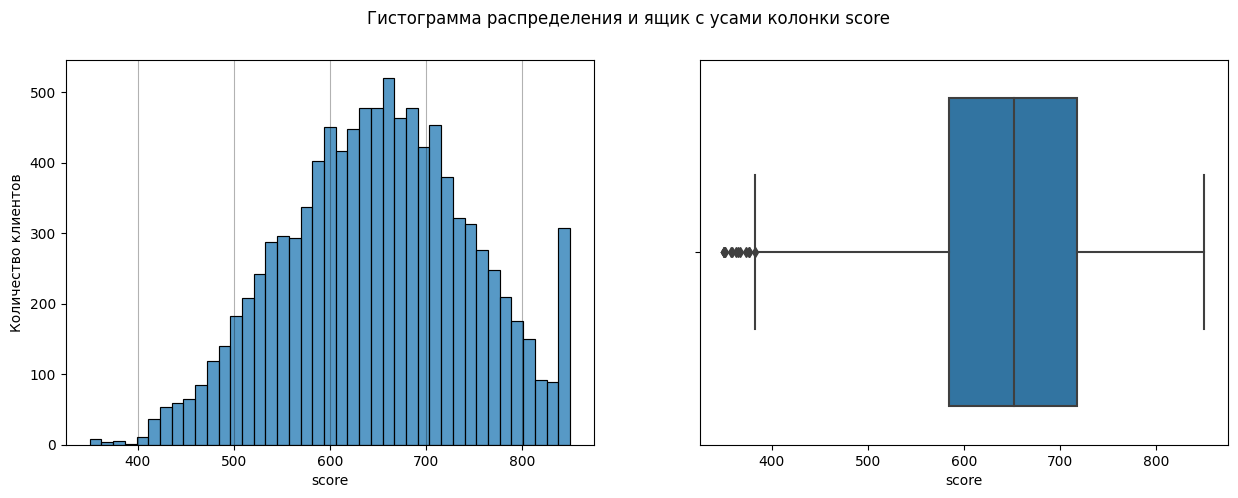

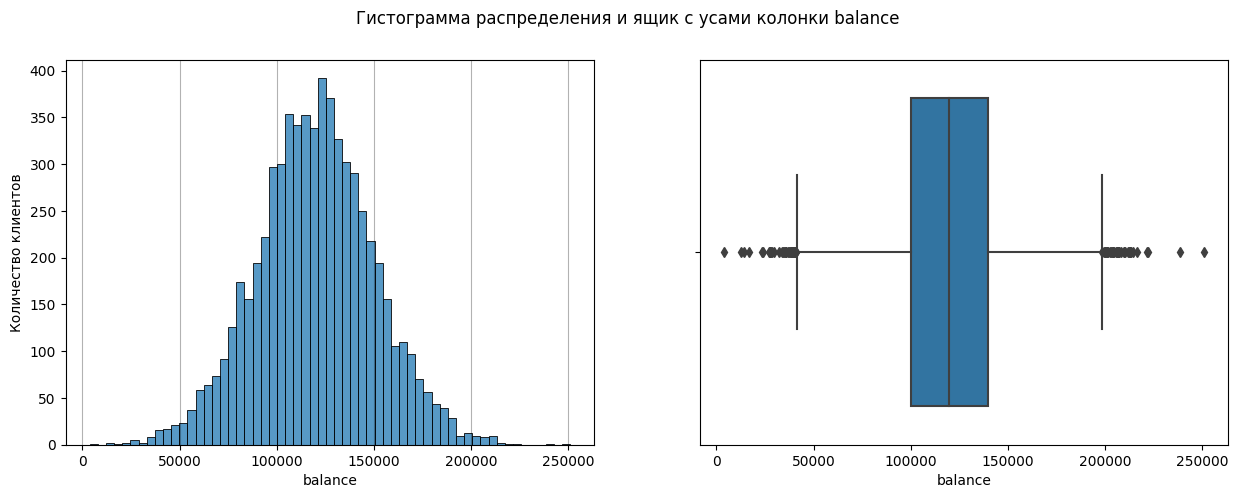

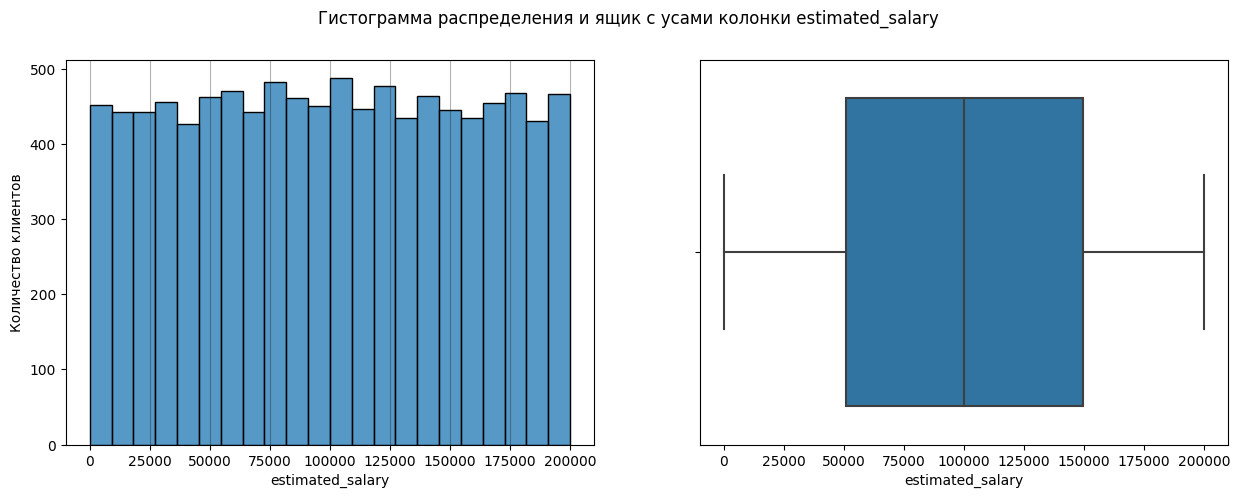

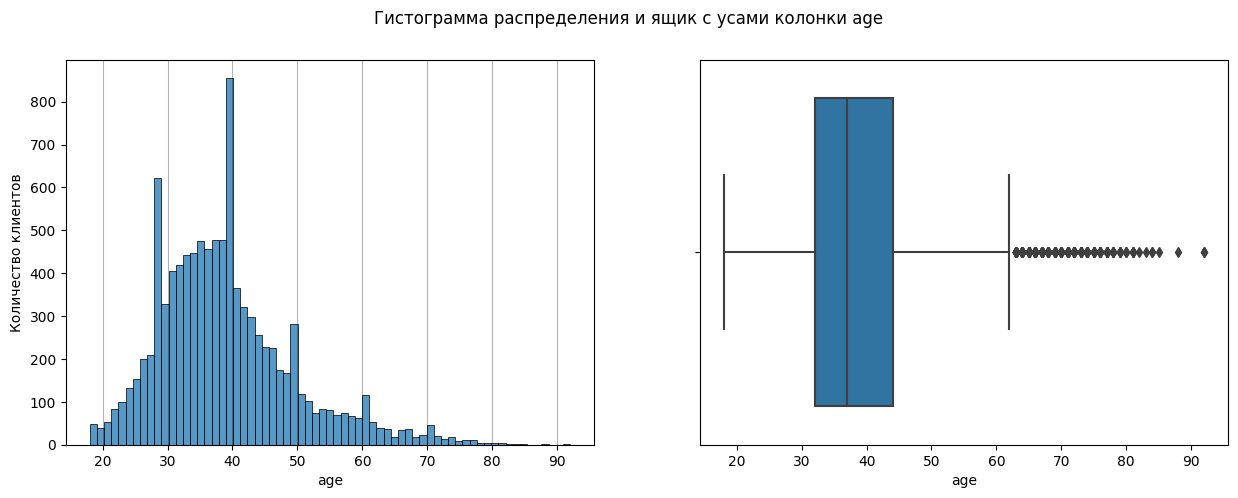

In [ ]:
for i in ["score", "balance", "estimated_salary", "age"]:
  distribution(i)
  print()

1. Скоринг клиентов выглядит нормально, но присутствует высокое значение рейтинга у большой концентрации пользователей (около 300 пользователей) скоринг выше 840. Нужно посмотреть подробнее.
2. К колонке "баланс" добавить нечего. Скорее всего это просто баланс денег на счете.
3. Распределение "ожидаемой зарплаты" - выглядит интересно. Скорее всего присуствует "неофициальная" работа, или класический момент ухода от налогов (когда официальная зарплата по документам низкая).
4. По возрасту выбиваются 4 возраста: 26-27, 38-40, 48-50 и 60-62 года (скорее всего такие возрастные группы будут использованы для сегментации клиентов)

Посмотрим на высокий скоринг

In [ ]:
high_score = data.query('score > 840') #.groupby('city').agg('count')
high_score.groupby('city').agg({'user_id':'count'})

,user_id
city,
Ростов Великий,78
Рыбинск,67
Ярославль,146


In [ ]:
high_score.groupby('gender').agg({'user_id':'count'})

,user_id
gender,
Ж,138
М,153


In [ ]:
high_score.groupby('churn').agg({'user_id':'count'})

,user_id
churn,
0,233
1,58


In [ ]:
high_score.groupby('loyalty').agg({'user_id':'count'})

,user_id
loyalty,
0,134
1,157


Ничего удивительного в высоких рейтингах скоринга - не обнаружено

Посмотрим как распределены колонки `'products','objects','city','gender','loyalty','churn'`

Далее напишем функцию `aggregation`(см. подраздел "Функции") по отрисовке столбчатых диаграмм для колонок **с дискретными величинами**.

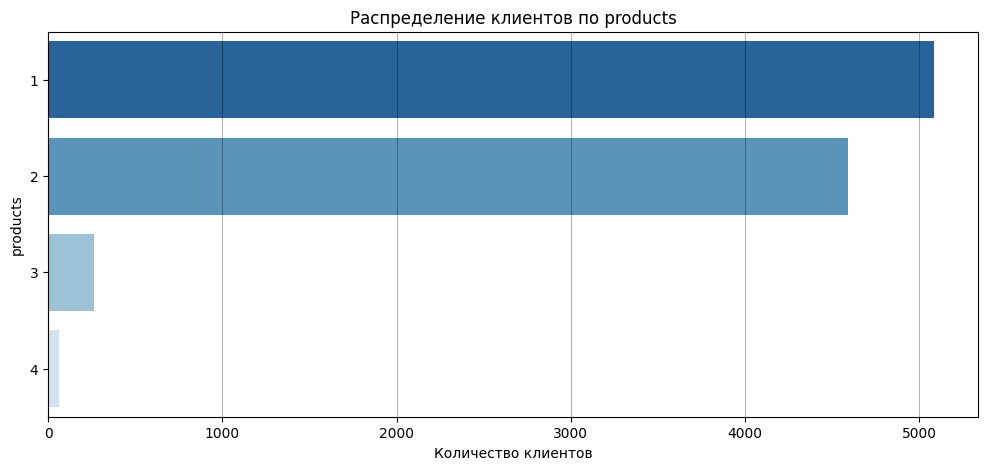

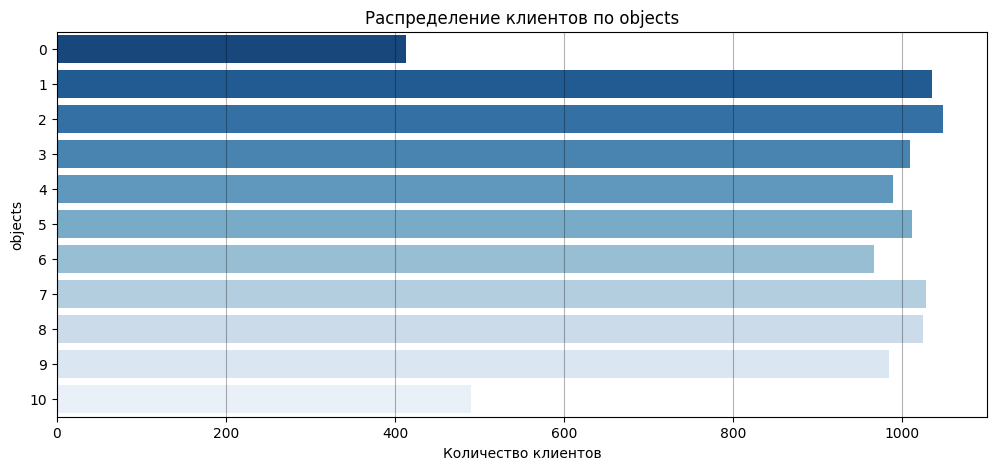

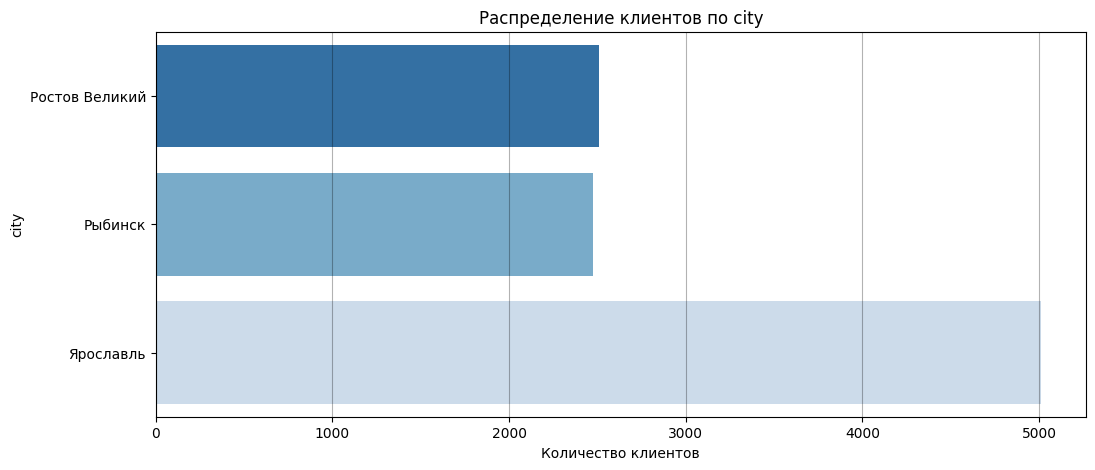

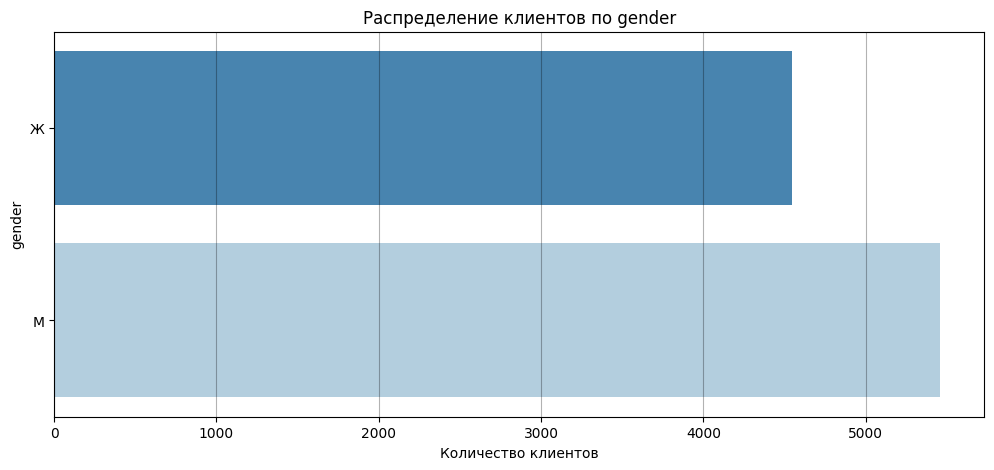

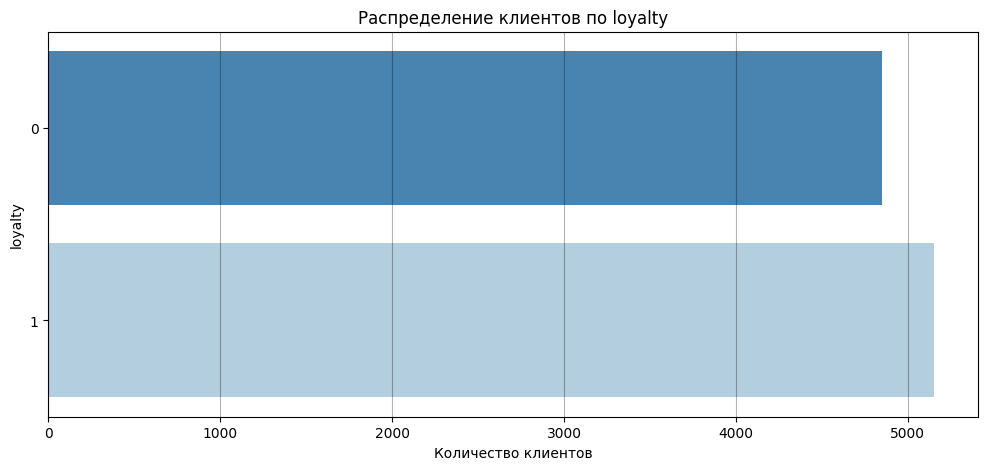

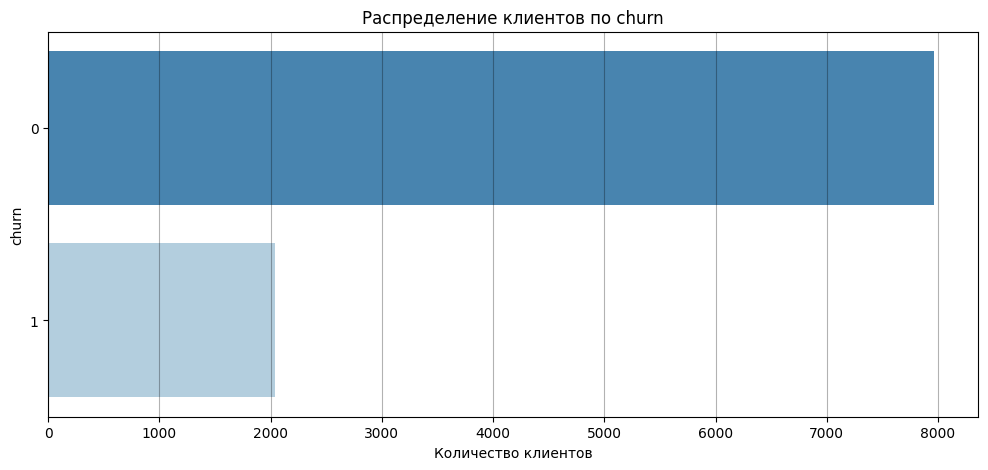

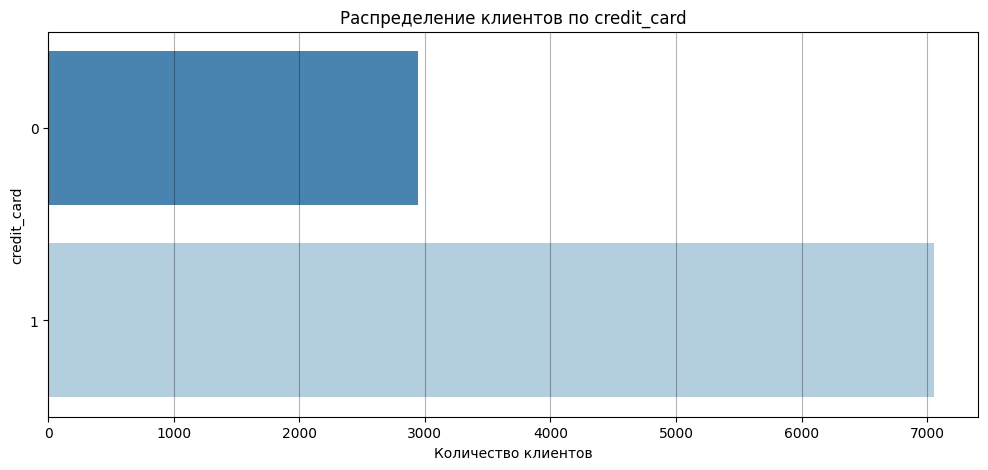

In [ ]:
for i in ["products","objects","city","gender","loyalty","churn","credit_card"]:
  aggregation(i)
  print()

1. Большинство клиентов пользуются 1-2 продуктами;
2. У подавляющего большинства пользователей в собственности от 1 до 9 (включительно) объектов недвижипости;
3. Больше половины клиетов банка из города Ярославль;
4. Мужчин немногим больше чем женщин;



**Вывод:**

1. Кредитный рейтинг клиентов выглядит нормально, но присутствует высокое значение рейтинга у большой концентрации пользователей (около 300 пользователей) скоринг выше 840.
2. К колонке "баланс" добавить нечего. Скорее всего это просто баланс денег на счете.
3. Распределение "ожидаемой зарплаты" - выглядит интересно. Скорее всего присуствует "неофициальная" работа, или класический момент ухода от налогов (когда официальная зарплата по документам низкая).
4. Выбиваются 4 возраста: 26-27, 38-40, 48-50 и 60-62 года (скорее всего такие возрастные группы будут использованы для сегментации клиентов)
5. Большинство клиентов пользуются 1-2 продуктами;
6. У подавляющего большинства пользователей в собственности от 1 до 9 (включительно) объектов недвижипости;
7. Больше половины клиетов банка из города Ярославль;
8. Мужчин немногим больше чем женщин;
9. Активных клиентов незначительно больше чем неактивных;
10. Наблюдается 20% оттока клиентов.
11. Можно переходить к исследовательскому анализу данных.


## Исследовательский анализ данных (EDA)
---

Построим матрицу корреляции для первичного взгляда на анализ данных

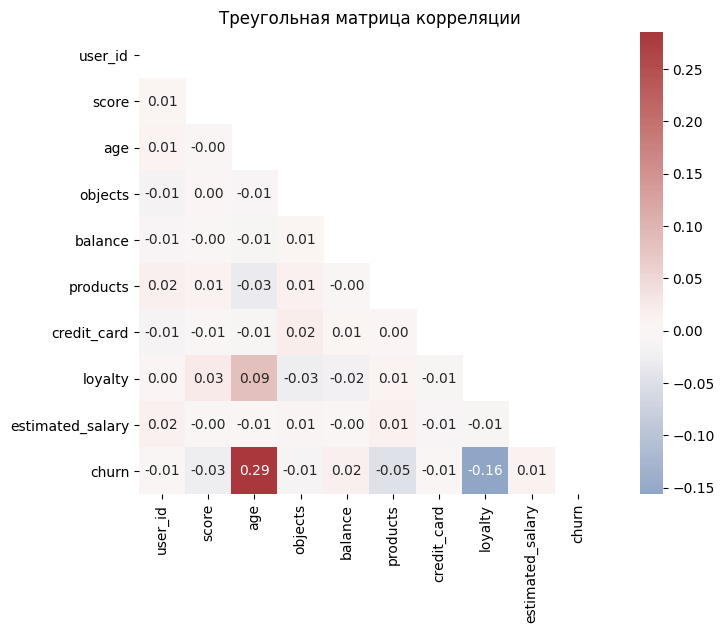

In [ ]:
# creating corr data
corr =  data.corr()

# creating the mask for masking upper traingle
mask = np.triu(np.ones_like(corr, dtype=bool))

# creating custom divergin palette
cmap = sns.color_palette("vlag", as_cmap=True)

# drawing matrix
plt.figure(figsize=(10, 6))
sns.heatmap(corr, mask=mask, center=0, annot=True,
            fmt='.2f', square=True, cmap=cmap)

plt.title('Треугольная матрица корреляции')
plt.show();

Рассмотрим эту матрицу с разбивки по городам:

In [ ]:
dummies_data = pd.get_dummies(data, prefix='dummie', prefix_sep='_', dummy_na=False, columns=['city','gender'], sparse=False, drop_first=False, dtype=None)
dummies_data

,user_id,score,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn,dummie_Ростов Великий,dummie_Рыбинск,dummie_Ярославль,dummie_Ж,dummie_М
0,15677338,619,42,2,NaN,1,1,1,101348.88,1,0,0,1,1,0
1,15690047,608,41,1,83807.86,1,0,1,112542.58,0,0,1,0,1,0
2,15662040,502,42,8,159660.80,3,1,0,113931.57,1,0,0,1,1,0
3,15744090,699,39,1,NaN,2,0,0,93826.63,0,0,0,1,1,0
4,15780624,850,43,2,125510.82,1,1,1,79084.10,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,15648965,771,39,5,NaN,2,1,0,96270.64,0,0,0,1,0,1
9996,15612628,516,35,10,57369.61,1,1,1,101699.77,0,0,0,1,0,1
9997,15627268,709,36,7,NaN,1,0,1,42085.58,1,0,0,1,1,0
9998,15725091,772,42,3,75075.31,2,1,0,92888.52,1,1,0,0,0,1


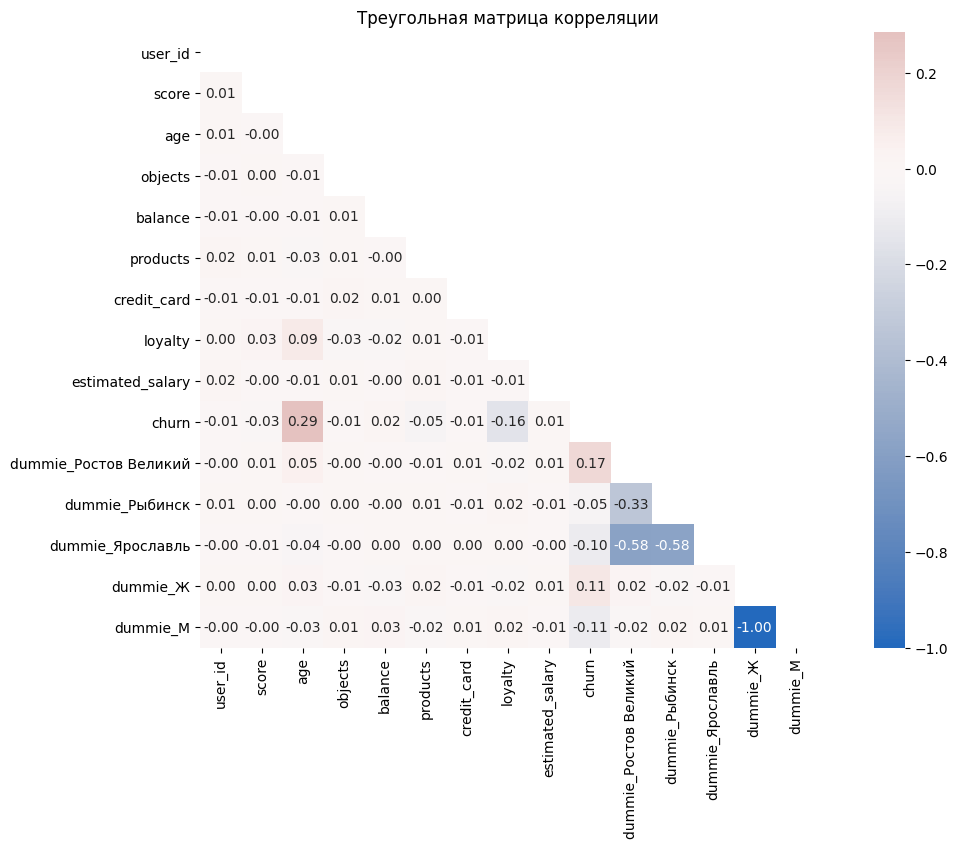

In [ ]:
# creating corr data
corr1 =  dummies_data.corr()

# creating the mask for masking upper traingle
mask1 = np.triu(np.ones_like(corr1, dtype=bool))

# creating custom divergin palette
cmap1 = sns.color_palette("vlag", as_cmap=True)

# drawing matrix
plt.figure(figsize=(15, 8))
sns.heatmap(corr1, mask=mask1, center=0, annot=True,
            fmt='.2f', square=True, cmap=cmap)

plt.title('Треугольная матрица корреляции')
plt.show();

1. Явной сильной корреляции не обнаружено;
2. Сильнее всего коррелирует с оттоком - возраст клиентов (уже второе упоминание возраста и оттока);
3. Активность клиентов обратнопропорциональна оттоку;
4. Интересный факт: Ростов Великий "коррелирует" с оттоком, а Ярославль наоборот.

Посмотрим на графики распеределений и ящики с усами в разбивке по "отточному" признаку, используя написанную функцию `churn_distribution`, которая рисует гистограммы и ящики с усами, для нужных колонок (с непрерывными величинами) датасета с разбивкой по отточному признаку.

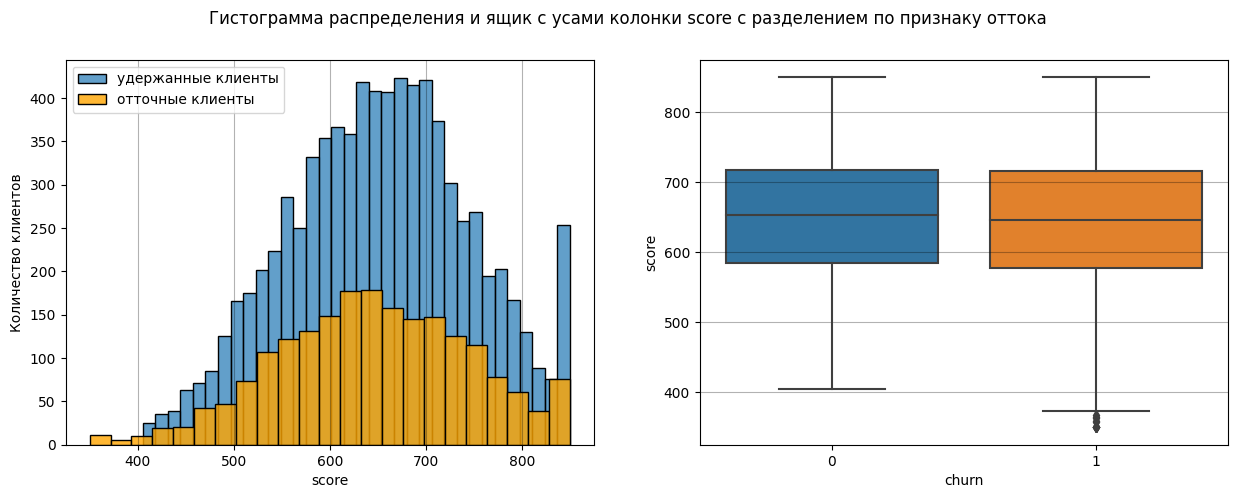

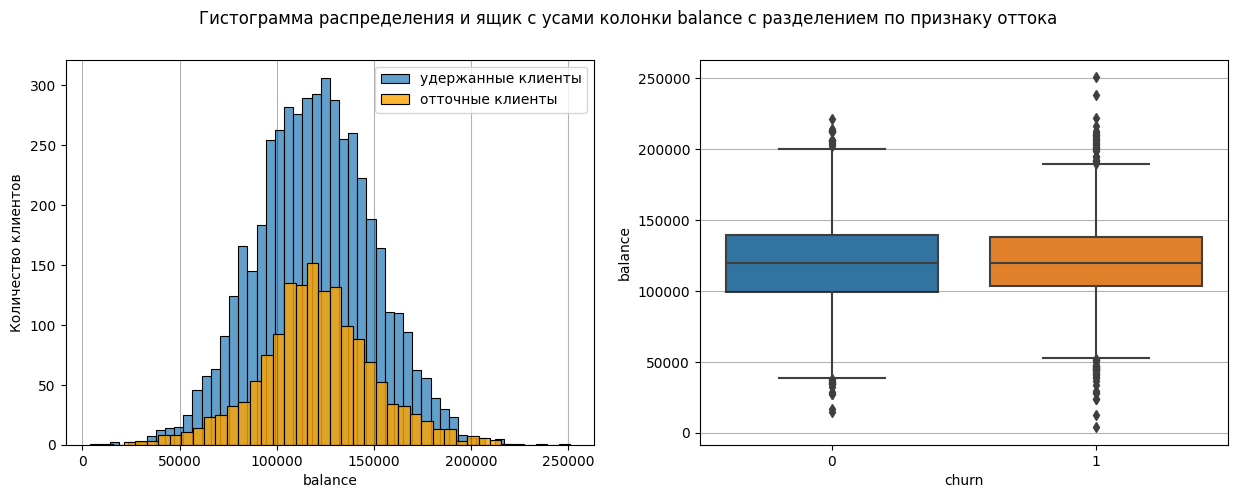

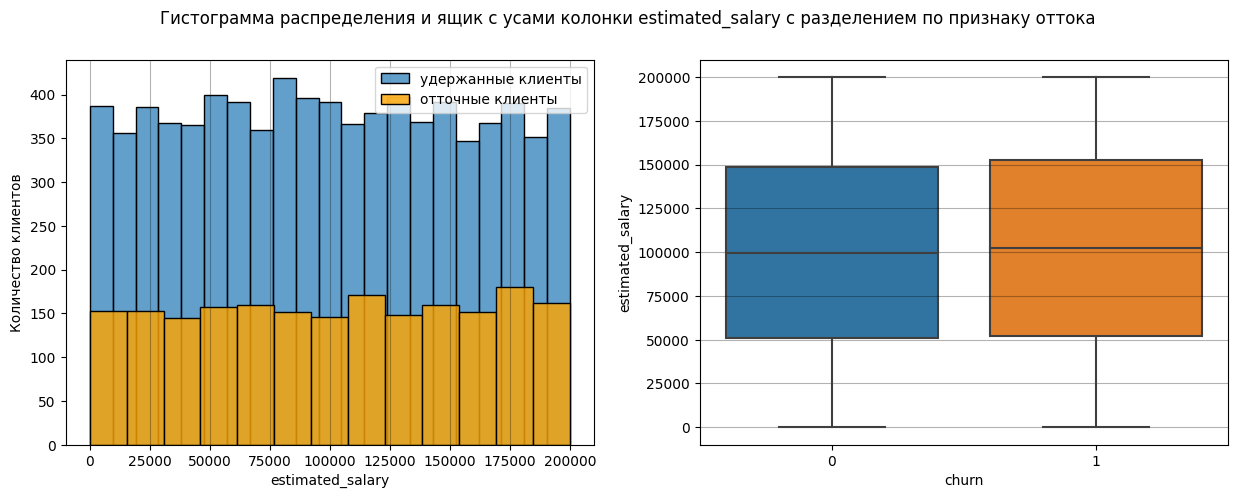

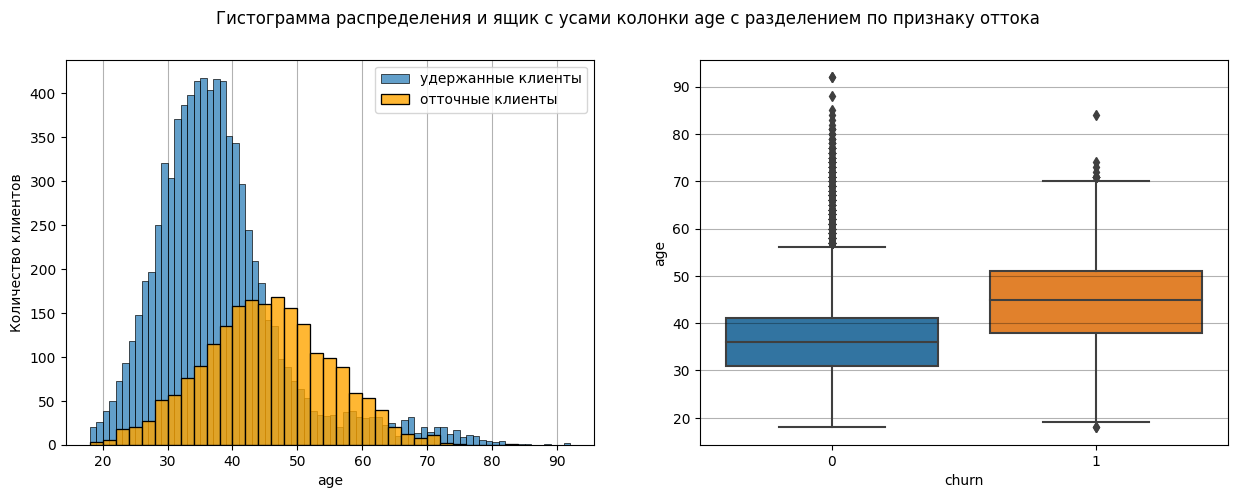

In [ ]:
for i in ["score", "balance", "estimated_salary", "age"]:
  churn_distribution(i)

Вот и зацепка по возрастной группе. Распределение оттока сдвинуто по возрасту. Взглянем подробнее.

In [ ]:
data.groupby('churn').agg('median')

,user_id,score,age,objects,balance,products,credit_card,loyalty,estimated_salary
churn,,,,,,,,,
0,15734279,653,36,5,119791.215,2,1,1,99645.04
1,15731699,646,45,5,119948.090,1,1,0,102460.84


1. Распределения по всем колонкам, с разбивкой по признаку отточности выглядят нормально, за исключением колонки возраста;
2. При анализе графиков распределения возраста с разбивкой по признаку отточности, можно заметить, что перестают пользоваться услугами банка люди старше на 9 лет (36 и 45 лет).

Посмотрим на "табличные" ящики с усами по возрасту с разбивкой по оттоку:

In [ ]:
data.groupby('churn')['age'].describe().T

churn,0,1
count,7963.000000,2037.000000
mean,37.408389,44.837997
std,10.125363,9.761562
min,18.000000,18.000000
25%,31.000000,38.000000
50%,36.000000,45.000000
75%,41.000000,51.000000
max,92.000000,84.000000


**75% отточных клиентов** имеют возраст **38+.**

Посмотрим на графики доли клиентов в разбивке по "отточному" признаку, используя написанную функцию `churn_aggregation`, которая строит столбчатые диаграмы, для нужных колонок (с дискретыми величинами) датасета с разбивкой по отточному признаку

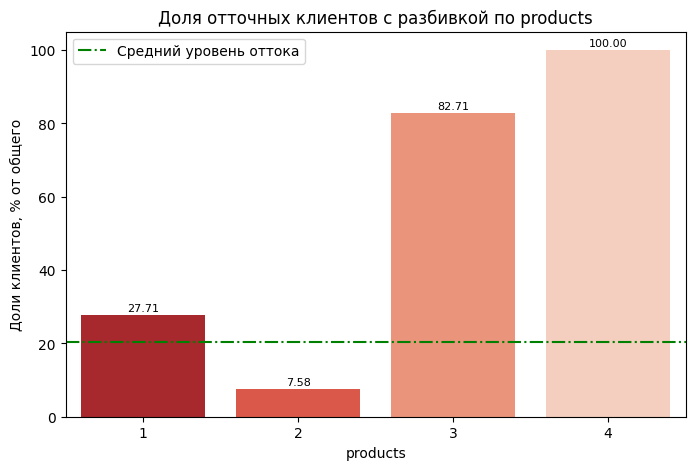

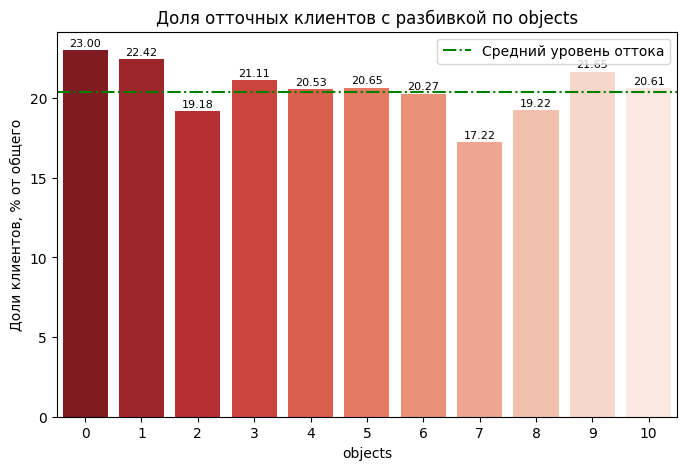

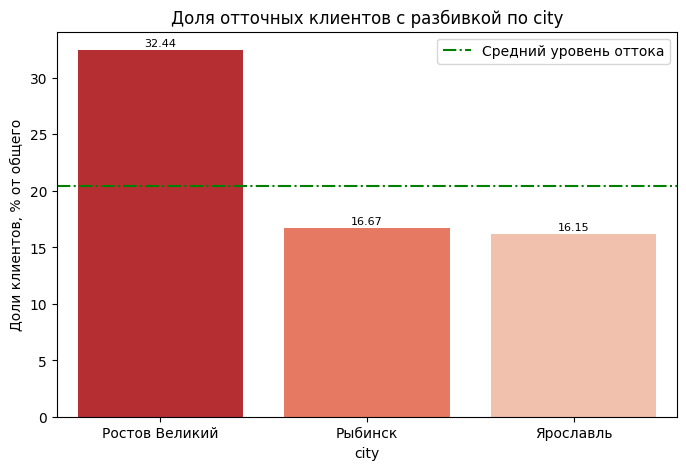

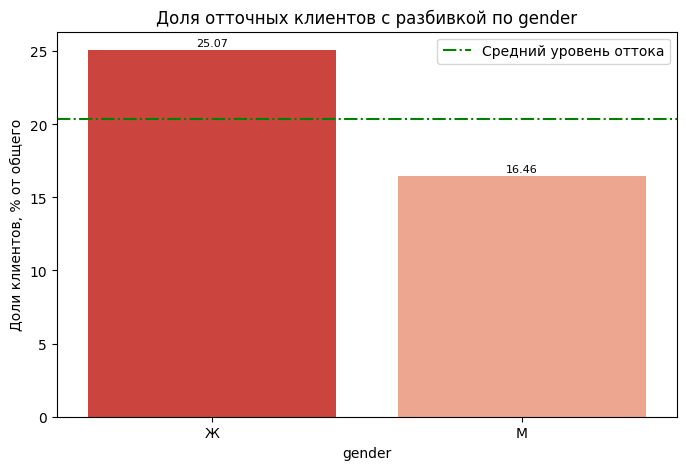

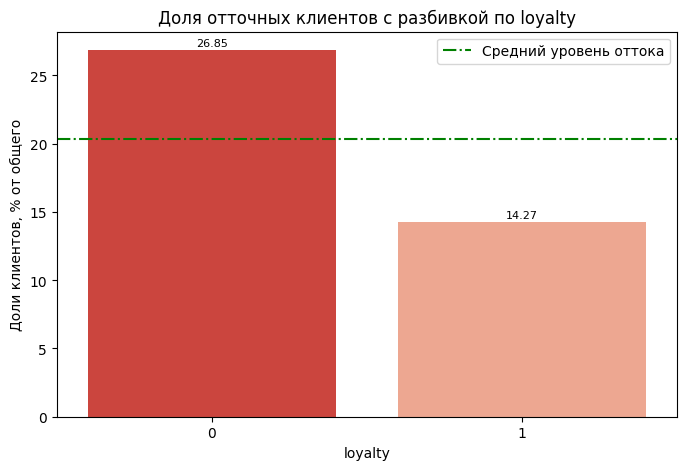

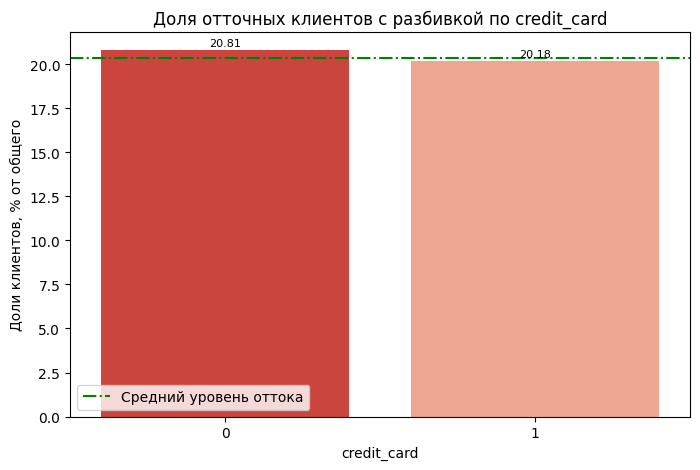

In [ ]:
for i in ["products","objects","city","gender","loyalty","credit_card"]:
  churn_aggregation(i)
  print()

**Вывод:**
1. Очевидный замеченый признак отточности клиентов - возрастная группа старше 38 лет;
2. Клиенты, пользующиеся 1,3,4 продуктами (доли оттока 27.71, 82.71 и 100% соответственно);
3. Количество объектов в собственности - не влияет на отточность;
4. Клиенты из Ростова Великово - почти в 2 раза более "отточны" чем из Рыбинска или Ярославля (32.44, против 16.67 и 16.15%);
5. Женщины немногом чаще пререстают пользоваться услугами банка - 25% оттока, против 16.46% у мужчин;
6. Неактивные клиенты - 26.85% оттока. Активные - 14.27%;
7. Наличие кредитной карты - не влияет на "отточность".

**Подготовка сегментации**

При аггрегации предыдущих выводов, можно сделать несколько групп, с показателем оттока выше 20%, по признакам:
1. Старше 38 лет;
2. Пользователи 1,3,4 продуктов;
3. Из города Ростов Великий;
4. Женщины;
5. Неактивные клиенты.

Посмотрим на долю отточности клиентов, по выбранным признакам:

In [ ]:
(data
    .query('age > 38')
    .groupby(['gender','city','products'])
    .agg(count=('age','count'), churn=('churn','mean'))
    .sort_values(by='churn', ascending=False)
)

count     churn
gender city           products                 
М      Ярославль      4             9  1.000000
Ж      Ростов Великий 4             9  1.000000
М      Рыбинск        4             1  1.000000
Ж      Рыбинск        4             4  1.000000
М      Ростов Великий 4            10  1.000000
Ж      Ярославль      4            15  1.000000
М      Ростов Великий 3            33  0.969697
Ж      Рыбинск        3            27  0.962963
       Ростов Великий 3            37  0.945946
       Ярославль      3            41  0.926829
М      Рыбинск        3            10  0.900000
       Ярославль      3            31  0.774194
Ж      Ростов Великий 1           359  0.643454
М      Ростов Великий 1           351  0.584046
Ж      Ярославль      1           538  0.442379
       Рыбинск        1           264  0.371212
М      Ярославль      1           594  0.321549
       Рыбинск        1           324  0.277778
Ж      Ростов Великий 2           209  0.267943
       Рыбинск        2           219  0.178082
М      Ростов Великий 2           232  0.155172
Ж      Ярославль      2           395  0.139241
М      Рыбинск        2           247  0.105263
       Ярославль      2           477  0.073375

**Важнейший признак - количество продуктов, которыми пользуются клиенты.** Показатель оттока, который выше среднего, **у пользователей с 1,3,4 продуктов**. Однако в городе Ростов Великий - доля отточности у женщин выше средней, даже в случае пользования 2-мя продуктами.

Посмотрим отдельно на город Ростов Великий, отдельно:

In [ ]:
(data
    .query('city == "Ростов Великий"')
    .groupby(['products','gender'])
    .agg(count=('age','count'), age=('age','mean'), churn=('churn','mean'))
    .sort_values(by='churn', ascending=False)
)

count        age     churn
products gender                            
4        Ж          14  43.071429  1.000000
         М          10  46.300000  1.000000
3        М          43  43.627907  0.930233
         Ж          53  43.679245  0.867925
1        Ж         664  40.668675  0.471386
         М         685  40.478832  0.386861
2        Ж         462  38.922078  0.162338
         М         578  37.743945  0.088235

**В Ростове Великом средний показатель отточности у женской половины** - ниже чем средний по всем данным, однако **в 2 раза выше чем у мужчин**.

Посмотри по признаку лояльности:

In [ ]:
(data
 .query('loyalty == 0')
 .groupby(['gender','city','products'])
 .agg(count=('age','count'),age=('age','median'), churn=('churn','mean'))
 .sort_values(by='churn', ascending=False)
)

count   age     churn
gender city           products                       
М      Ярославль      4             5  44.0  1.000000
Ж      Ростов Великий 4            10  43.0  1.000000
М      Рыбинск        4             2  41.0  1.000000
Ж      Рыбинск        4             3  50.0  1.000000
М      Ростов Великий 4             4  45.5  1.000000
Ж      Ярославль      4             7  45.0  1.000000
       Ростов Великий 3            29  45.0  0.931034
М      Ростов Великий 3            26  42.0  0.923077
Ж      Ярославль      3            36  42.5  0.916667
       Рыбинск        3            26  43.0  0.846154
М      Рыбинск        3            12  39.5  0.833333
       Ярославль      3            24  41.0  0.791667
Ж      Ростов Великий 1           373  40.0  0.546917
М      Ростов Великий 1           347  39.0  0.492795
Ж      Рыбинск        1           240  39.0  0.400000
       Ярославль      1           548  38.0  0.363139
М      Рыбинск        1           308  38.0  0.266234
       Ярославль      1           705  37.0  0.243972
Ж      Ростов Великий 2           222  37.0  0.189189
М      Ростов Великий 2           250  36.0  0.144000
Ж      Рыбинск        2           257  36.0  0.128405
       Ярославль      2           508  35.0  0.096457
М      Рыбинск        2           317  36.0  0.075710
       Ярославль      2           590  36.0  0.047458

Медианный возраст у **неактивных клиентов, склонных к отточности - 37 лет.**

Подытожим:

**Первый сегмент:** Клиенты, использующие 1, 3 или 4 продукта, 39 и более лет.

**Второй сегмент:** Женщины, из города Ростов Великий;

**Третий сегмент:** Неактивные клиенты от 37 лет.

Проведем проверку серментов исключением, в порядке, который представлен выше:

In [ ]:
data_first = data.query('age > 38 and churn == 1 and products != 2')
list_first = data_first['user_id'].tolist()
print('Количество отточных клиентов в первом сегменте, от общего датасета:',len(data_first))


Количество отточных клиентов в первом сегменте, от общего датасета: 1265


In [ ]:
data_1 = data.query('user_id not in @list_first')
print('Количество всех клиентов в датасете, без учета первого сегмента:',len(data_1))

Количество всех клиентов в датасете, без учета первого сегмента: 8735


In [ ]:
data_second = data_1.query('loyalty == 0 and churn == 1 and age > 36')
list_second = data_second['user_id'].tolist()
print('Количество отточных клиентов во втором сегменте, от датасета без первого сегмента:',len(data_second))

Количество отточных клиентов во втором сегменте, от датасета без первого сегмента: 222


In [ ]:
data_2 = data_1.query('user_id not in @list_second')
print('Количество всех клиентов в датасете, без учета первого и второго сегментов:',len(data_2))

Количество всех клиентов в датасете, без учета первого и второго сегментов: 8513


In [ ]:
data_third = data_2.query('city == "Ростов Великий" and churn == 1 and gender == "Ж"')
list_third = data_third['user_id'].tolist()
print('Количество отточных клиентов в третьем сегменте, от датасета без первого и второго сегментов:',len(data_third))

Количество отточных клиентов в третьем сегменте, от датасета без первого и второго сегментов: 129


In [ ]:
data_3 = data_2.query('user_id not in @list_third')
print('Количество всех клиентов в датасете, без отточных сегментов:', len(data_3))

Количество всех клиентов в датасете, без отточных сегментов: 8384


Соберем расчеты в таблицу

In [ ]:
details = {
    'Датасет' : ['Оригинальный', 'Без I сегмента', 'Без I+II сегмента', 'Без сегментов'],
    'Размер' : [len(data), len(data_1), len(data_2), len(data_3)],
    'Доля отточных клиентов, %' : [round(data['churn'].mean()*100,2), round(data_1['churn'].mean()*100,2), round(data_2['churn'].mean()*100,2), round(data_3['churn'].mean()*100,2)],
}

df = pd.DataFrame(details)

df

,Датасет,Размер,"Доля отточных клиентов, %"
0,Оригинальный,10000,20.37
1,Без I сегмента,8735,8.84
2,Без I+II сегмента,8513,6.46
3,Без сегментов,8384,5.02


Таким образом, применяя действия по удержанию отточных сегментов клиентов, можно удержать до 16.16% клиентов, при среднем показателе отточности 20.37%

## Проверка гипотез
---

Проверим эти высказывания методом проверки гипотезы о равенстве среднего двух совокупностей и рассчитаем дисперсии, используя `ttest_ind`, так как мы не знаем равны ли дисперсии выборок, и дополнительно установим параметр `equal_var=False`.

Зададим значение значимоси (критерий Стьюдента) в 5%, руководствуясь общепринятыми мерками.

### Гипотеза 1
---

* Н0: Доход между ушедшими клиентами и оставшимися - **одинаковый**.
    
* Н1: Доход между ушедшими клиентами и оставшимися - **различается**.

In [ ]:
results = sc.stats.ttest_ind(data.query('churn == 1')['estimated_salary'], data.query('churn == 0')['estimated_salary'], equal_var=False)
print('P-value:',results.pvalue)

alpha = 0.05

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

P-value: 0.228924613051458
Не получилось отвергнуть нулевую гипотезу


Не получилось отвергнуть нулевую гипотезу, и тем самым, получается что нет статистической разницы в доходах удержжанных клиентов и отточных, что дополнительно подтвержается (хоть и не точно) ящиками с усами доходов отточных клиентов и удержанных.


### Гипотеза 2
---

* Н0: Скоринг между ушедшими клиентами и оставшимися - **одинаковый**
    
* Н1: Скоринг между ушедшими клиентами и оставшимися - **различается**.

In [ ]:
results = sc.stats.ttest_ind(data.query('churn == 1')['score'], data.query('churn == 0')['score'], equal_var=False)
print('P-value:',results.pvalue)

alpha = 0.05

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

P-value: 0.008464728991832877
Отвергаем нулевую гипотезу


Отвергаем нулевую гипотезу, и принимаем петвую, следовательно баллы скоринга отточных клиентов и удержанных - статистически различаются. Как пример - ящик с усами колонки score с разбивкой по churn.

## Общий вывод
___



**В результате изучения датасета `bank_dataset.csv`:**

1. Датасет содержит 10000 строк;
2. Пропуски имеются в колонке "Balance";
3. Явных дубликатов нет;
4. Типы данных соответствуют логике названий колонок;
5. Необходимо привести названия колонок к единому стилю;
6. Возраст клиентов от 18 до 92 лет;
7. Количество объектов в собственности от 0 до 10;
8. Баллы кредитного скоринга от 350 до 850;
9. Количество продуктов банка, которыми пользуется клиенты от 1 до 4;
10. Нужно проверить на наличие неявных дубликатов;
11. Кредитными картами пользуются 70% клиентов;
12. 51% клиентов - активные;
13. Средний отток - 20,37%.
---
**Была произведена предобработка данных** и первичный взгляд на характеристики колонок, в результате чего получена информация:

1. Кредитный рейтинг клиентов выглядит нормально, но присутствует высокое значение рейтинга у большой концентрации пользователей (около 300 пользователей) скоринг выше 840.
2. Распределение "ожидаемой зарплаты" - выглядит интересно. Скорее всего присутствует "неофициальная" работа, или классический момент ухода от налогов (когда официальная зарплата по документам низкая).
3. Большинство клиентов пользуются 1-2 продуктами;
4. У подавляющего большинства пользователей в собственности от 1 до 9 (включительно) объектов недвижимости;
5. Больше половины клиентов банка из города Ярославль;
6. Мужчин немногим больше чем женщин;
7. Активных клиентов незначительно больше чем неактивных.
---

**В результате углубленного (исследовательского) анализа данных, замечено:**

1. Очевидный замеченный признак отточности клиентов - возрастная группа старше 38 лет;
2. Клиенты, пользующиеся 1,3,4 продуктами (доли оттока 27.71, 82.71 и 100% соответственно);
3. Количество объектов в собственности - не влияет на отточность;
4. Клиенты из Ростова Великого - почти в 2 раза более "отточны" чем из Рыбинска или Ярославля (32.44, против 16.67 и 16.15%);
5. Женщины немногом чаще перестают пользоваться услугами банка - 25% оттока, против 16.46% у мужчин;
6. Неактивные клиенты - 26.85% оттока. Активные - 14.27%;
7. Наличие кредитной карты - не влияет на "отточность".
---
**По результатам исследовательского анализа данных были выявлены сегменты** (группы, объединенные несколькими признаками), которые являются **наиболее отточными:**

**Первый сегмент:** Клиенты, использующие 1, 3 или 4 продукта, 39 и более лет.

**Второй сегмент:** Женщины, из города Ростов Великий;

**Третий сегмент:** Неактивные клиенты от 37 лет.

Тем самым, применяя определенные действия (рекомендации представленны ниже) по удержанию отточных сегментов клиентов, **можно удержать до 16.16% клиентов**, **при среднем показателе отточности в 20.37%**.

---
**Рекомендации:**

**Первый сегмент:** Клиенты, использующие 1, 3 или 4 продукта, 39 и более лет:

Можно предложить **бонусы, скидки или специальные привилегии для клиентов**, которые используют несколько продуктов банка. Клиенты уходят, возможно, потому что они разочаровываются в одном или нескольких продуктах банка.

**Персональный финансовый консультант для пользователей 3+ продуктов**, который будет помогать им управлять их финансами, предлагать инвестиционные возможности и помогать достигать финансовых целей.

Регулярная обратная связь через **продвинутую систему чата технической поддержки**:
Можно реализовать техническую поддержку в ормате чата, без использования сложных экономических терминов, для лучшего понимания функционирования банковской системы обычным пользователем.
Проводите регулярные анализы обращений в техподдержку, чтобы оценить их потребности и предложить улучшения или новые продукты, которые могут соответствовать их ситуации.

---

**Второй сегмент:** Женщины из города Ростов Великий:

**Специальные предложения для женщин:** Возможна разработка специальных финансовых продуктов и услуг, которые соответствуют потребностям и интересам женщин.

**Женские финансовые мероприятия:** мероприятия и семинары по финансовой грамотности, ориентированные на женщин. Это может быть школа финансового планирования, форум для обмена опытом и советами или лекции от успешных женщин в финансовой сфере.

---

**Третий сегмент:** Неактивные клиенты от 37 лет:

**Реактивация через персональный контакт:** через систему продвинутой поддержки в формате чата, чтобы вернуть их в активное использование продуктов банка.

Персонализированные предложения, построеные на основе маркетинговой системы, основанные на предыдущих операциях и интересах клиентов. Может быть, клиенты могут заинтересоваться уникальными условиями или скидками на другие продукты банка.
